# Эксперименты с временным рядом стоимости алюминия

In [2]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import torch
from darts import TimeSeries
from darts.metrics import mape
from darts.models import AutoARIMA, ExponentialSmoothing, Prophet, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy
import random

In [3]:
import optuna
from functools import partial

## Data

In [4]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [5]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

In [6]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (282, 67)


In [7]:
df.describe()

,bloomberg_metals_price_mean_4,chalco_adj_std_13,usa_inflation_value_shift_13,usd_to_hkd_increment_by_mean_26,rual_price_std_26,ftse_index_std_13,hongqiao_adj_std_4,alcoa_price_std_4,norsk_hydro_adj_std_4,bloomberg_metals_price_std_9,chalco_price_std_4,eu_inflation_value_increment_by_mean_26,ftse_index_std_4,USD_JPY_rate_increment_by_mean_26,ftse_index_change_mean_52,eu_inflation_value_std_13,rual_price_std_13,baltic_dry_index_std_9,export_australia_value_std_26,australia_pmi_std_26,sp_metals_price_std_4,bloomberg_metals_price_std_4,USD_EUR_rate_std_26,import_usa_value_std_13,export_usa_value_std_9,guinea_inflation_std_26,sp_metals_price_std_9,usa_gdp_increment_value,norsk_hydro_adj_increment_by_mean_26,rual_price_std_4,...,log10_kaiser_volume_std_9,brazil_inflation_std_26,log10_kaiser_volume_std_4,mosexchange_value_std_4,shanghai_index_std_4,import_brazil_value_std_26,import_usa_value_increment_by_mean_26,ftse_index_change_std_13,guinea_inflation_std_13,export_usa_value_std_26,export_usa_value_increment_by_mean_26,USD_EUR_rate_std_13,ftse_index_change_mean_26,export_brazil_value_std_13,sp_metals_change_std_9,rual_price_change_mean_26,export_brazil_value_increment_by_mean_26,rual_price_change_std_26,rual_price_change_std_13,china_pmi2_value_std_13,log10_alcoa_volume_std_13,log10_alcoa_volume_std_9,export_china_value_increment_by_mean_26,covid,after_feb,lme_price_smooth,target_1,target_2,target_3,target_4
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,...,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,281.000000,280.000000,279.000000,278.000000
mean,138.559113,0.319516,0.309423,-0.000843,4.249986,273.543396,0.259927,1.800147,1.449233,4.563441,0.168945,0.227759,139.332413,1.663174,0.111457,0.181089,2.888936,264.172943,38.807678,1.468726,61.469463,2.826630,0.015950,130076.195312,143881.859375,0.477580,95.824181,2.179436,1.091418,1.485700,...,0.181229,0.768479,0.155476,171.235138,54.980236,18.217363,17068.943359,1.026909,0.329527,260680.625000,3.658002e+04,0.010979,0.086928,11.451565,0.859504,0.069141,1.836829,1.367122,1.222799,1.929837,0.131023,0.120998,4.268951e+04,0.228467,0.162726,2187.586670,-0.311324,-0.602007,-0.583585,-0.399618
std,27.089277,0.184627,0.315599,0.019017,2.630195,177.179459,0.196332,1.611941,1.076748,3.385589,0.137156,0.419358,106.679466,4.338950,0.205780,0.113887,2.095899,173.432083,11.945754,0.910203,42.420738,2.543974,0.008652,86156.429688,199285.578125,0.447644,59.999840,3.307303,5.963383,1.465832,...,0.074597,0.416949,0.079136,149.405640,60.812988,7.940274,280205.500000,0.880100,0.404302,222130.921875,3.697457e+05,0.006033,0.254548,7.060465,0.334876,0.259328,17.119184,0.726316,0.823724,2.333842,0.064236,0.058733,3.875421e+05,0.388796,0.300243,440.553650,54.538860,88.763176,113.060982,135.670944
min,92.510361,0.052547,-0.800000,-0.061387,0.997777,54.833698,0.012340,0.180923,0.099812,0.709486,0.013164,-0.456593,17.186796,-9.918187,-0.298297,0.000000,0.633519,32.954060,20.460823,0.315536,1.132393,0.132410,0.004820,13935.265625,4.350456,0.047933,25.982565,-7.500000,-17.344406,0.151132,...,0.062280,0.075746,0.025223,11.993413,3.007912,5.112617,-739684.187500,0.358280,0.000000,34.463089,-1.048385e+06,0.003077,-0.383544,1.025469,0.357106,-0.644664,-45.708199,0.519534,0.443797,0.123188,0.063388,0.044006,-2.087662e+06,0.000000,0.000000,1479.717651,-250.823135,-405.278900,-482.037415,-501.510193
25%,115.814018,0.181782,0.114286,-0.007432,2.388422,157.340839,0.104818,0.797250,0.685221,2.282125

In [8]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 26 точек (то есть 26 недель = 6 месяцев)
# out-of-time выборка будет использована лишь в самом конце

In [9]:
import datetime

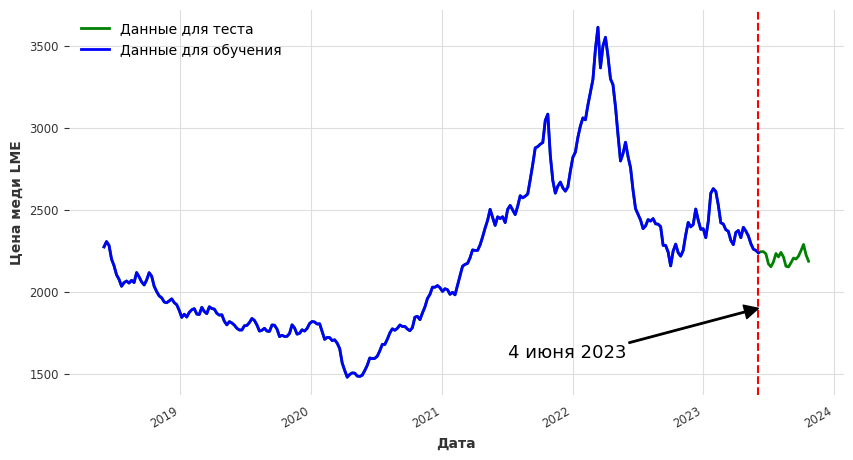

In [10]:
# Рисуем
# Рисуем
fig, ax = plt.subplots(figsize=(10, 5))
data_ts.plot(label="Данные для теста", color='g')
ts.plot(label="Данные для обучения", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('4 июня 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
#plt.savefig('preview.png', dpi=400, format='png')

In [26]:
best_params

{'trend': <ModelMode.ADDITIVE: 'additive'>,
 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
 'seasonal_periods': 33}

In [49]:
model = ExponentialSmoothing(**best_params)
model.fit(data_ts[:-OUT_OF_TIME_DIM])
pred = model.predict(4)

<Axes: xlabel='date'>

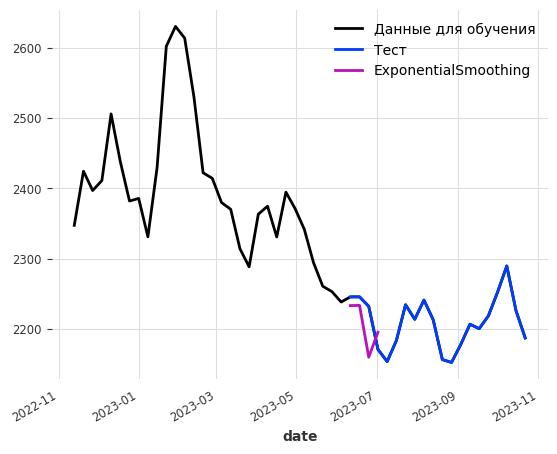

In [50]:
data_ts[-50:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM:].plot(label='Тест')
pred.plot(label='ExponentialSmoothing')

In [69]:
    out_of_time_metrics_refit = list()
    point=0
    model = ExponentialSmoothing(**best_params)
    prediction_curves=dict()
    while True:
            ts = data_ts[:-OUT_OF_TIME_DIM+point]
            model1 = deepcopy(model)
            model1.fit(series=ts)
            prediction = model1.predict(4)
 
            metric = mape(prediction, data_ts, intersect=True)
            out_of_time_metrics_refit.append(metric)
            point+=2
            prediction_curves[point]=prediction
            del model1
            if -OUT_OF_TIME_DIM+point==-4:
                break

/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [70]:
np.mean(out_of_time_metrics_refit), np.std(out_of_time_metrics_refit )

(3.2718322093512926, 1.9875613282333848)

In [71]:
ts = data_ts[:-OUT_OF_TIME_DIM]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

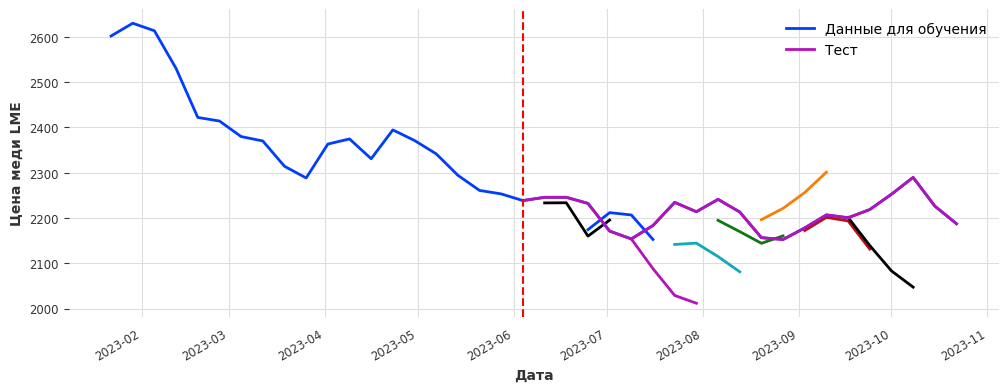

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
plt.savefig('pic3.png', dpi=400, format='png')

## Tools

### Cross-validation

In [11]:
# Использовать backtest нет смысла, так как в нем не реализована функция трансформации данных (Scaler)
# Судя по github darts на октябрь 2023 идет разработка данного модуля

# average_error = tcn_model.backtest(
#     series = ts_train,
#     past_covariates=
#     start=0.5,
#     forecast_horizon=17,
#     stride = 9
#     metric=mape,
#     reduction=np.mean,  # this is actually the default
#     retrain = True
#     verbose=True,
# )

# print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [12]:
def manual_backtest(model, ts, past_covariates, forecast_horizont=FORECAST_LEN, 
                    start_test=180, step = 10, save_curves=False,
                    rolling_window=False, window_size=None):
    '''
    Функция аналогична встроенной функции backtest
    '''
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test : start_test + int(forecast_horizont)]
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test : start_test + int(forecast_horizont)]
            
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            past_cov_test_scaled = scaler_past_cov.transform(past_cov_test)
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled,
                        past_covariates=past_cov_train_scaled)
            cur_pred_scaled = model1.predict(int(forecast_horizont),
                                             series=cur_train_scaled,
                                             past_covariates=past_cov_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Если экзогенных признаков нет  
        else:
            model1 = deepcopy(model)
            model1.fit(series=cur_train)
            cur_pred = model1.predict(int(forecast_horizont))
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) >= len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [18]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "trend" : trial.suggest_categorical("trend", [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE]),
        #"damped" : trial.suggest_categorical("damped", [True, False]),
        "seasonal" : trial.suggest_categorical("seasonal", [SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.NONE]),
        "seasonal_periods" : trial.suggest_int("seasonal_periods", 2, 52)
    }
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [104, 156])
    
    # build and train the model with these hyper-parameters:
    model = ExponentialSmoothing(
        **settings
    )

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(model, ts=ts, past_covariates=None, **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}", end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[print_callback])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    for key, value in study.best_trial.params.items():
        print("  {}: {}".format(key, value))
    return study

### Feature selection

In [42]:
def forward_selection(df, settings, settings_for_backtest, forecast_len = FORECAST_LEN, out_of_time_dim = OUT_OF_TIME_DIM):
    metrics_dict = dict()
    # Извлечем список признаков, важно, что в датасете признаки упорядочены по убыванию уровня корреляции
    all_features = df.drop(columns=['date','lme_price_smooth','target_1','target_2','target_3','target_4']).columns.values.copy()
    candidates = list()
    # Стартовая "лучшая" метрика
    last_min = 1e8
    k=0
    for feature in all_features:
        candidates.append(feature)

        ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
        ts = ts[:-out_of_time_dim]
        past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
        past_cov = past_cov[:-out_of_time_dim]
        
        model = LinearRegressionModel(
            **settings,
            output_chunk_length=4,
            random_state=42
        )
        
        print(candidates)
        
        metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
        mean_metric = np.mean(metrics)

        if mean_metric < 0.99*last_min:
            print(candidates)
            print('Metric:', mean_metric)
            print('===============')
            last_min = mean_metric
            k=0
        else:
            print(candidates)
            print('Metric increased:', mean_metric)
            print('===============')
            candidates.pop()
            k+=1
        
        if k>=6:
            break

    print('\n\n')
    print('Feature selection is completed')
    return candidates

In [22]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [56]:
def evaluation_without_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    
    df - датасет временного ряда
    out_of_time_dim - размер выборки out-of-time
    forecast_len - длина прогноза
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = LinearRegressionModel(**model_settings,output_chunk_length=4,random_state=42)

    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )

    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
        prediction_scaled = model.predict(int(forecast_len), series=cur_test_input_scaled, past_covariates=past_cov_test_input_scaled)
        prediction = scaler_ts.inverse_transform(prediction_scaled)
        metric = mape(prediction, out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

# def evaluation_with_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):

#     data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
#     data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
#     model = RandomForest(
#         **model_settings,
#         output_chunk_length=forecast_len,
#         n_jobs=16,
#         random_state=42
#         )
    
#     shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    
#     threshold = 0
#     metrics = list()
#     prediction_curves = {}
#     step = 1
#     shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
#     out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
#     out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
#     while True:
#         if threshold%3==0:
#             ts = data_ts[:-out_of_time_dim]
#             past_cov = data_past_cov[:-out_of_time_dim]

#             if backtest_settings["rolling_window"]==True:
#                 ts_train = ts[- backtest_settings["window_size"] : ]
#                 past_cov_train = past_cov[- backtest_settings["window_size"] : ]
#             else:
#                 ts_train = ts
#                 past_cov_train = past_cov

#             scaler_ts, scaler_past_cov = Scaler(), Scaler()
#             ts_train_scaled = scaler_ts.fit_transform(ts_train)
#             past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)

#             model.fit(series=ts_train_scaled,
#                       past_covariates=past_cov_train_scaled
#                      )
#             cur_test_input = out_of_time_ts[threshold : threshold + shift]
#             past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
#             cur_test_input_scaled = scaler_ts.transform(cur_test_input)
#             past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
#             prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
#             prediction = scaler_ts.inverse_transform(prediction_scaled) 
#             metric = mape(prediction, out_of_time_ts)
#             metrics.append(metric)
#             threshold+=step
#             prediction_curves[threshold]=prediction
#             if threshold + shift + int(forecast_len) > len(out_of_time_ts):
#                 break
#         else:
#             cur_test_input = out_of_time_ts[threshold : threshold + shift]
#             past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
#             cur_test_input_scaled = scaler_ts.transform(cur_test_input)
#             past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
#             prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
#             prediction = scaler_ts.inverse_transform(prediction_scaled)
#             metric = mape(prediction, out_of_time_ts)
#             metrics.append(metric)
#             threshold+=step
#             prediction_curves[threshold]=prediction
#             if threshold + shift + int(forecast_len) > len(out_of_time_ts):
#                 break

#     print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
#     return prediction_curves, metrics

def train_metric_evaluation(model_settings, backtest_settings, df, out_of_time_dim=OUT_OF_TIME_DIM, forecast_len=FORECAST_LEN, candidates=None):
    '''
    Функция для вычисления метрики на train выборке
    df - датасет всех данных
    model - модель
    out_of_time-dim - размер выборки out-of-time
    forecast_len - длина прогноза
    scaler_ts, scaler_past_cov - скейлеры
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = LinearRegressionModel(**model_settings,output_chunk_length=4,random_state=42)

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )
    
    start_point = 0
    metrics = list()
    step = 5
    while True:
        cur_test_input = ts[start_point : start_point + shift]
        past_cov_test_input = past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)

        prediction_scaled = model.predict(series=cur_test_input_scaled,
                                          past_covariates=past_cov_test_input_scaled,
                                          n=int(forecast_len))
        prediction = scaler_ts.inverse_transform(prediction_scaled)

        metric = mape(prediction, ts)
        metrics.append(metric)
        start_point+=step
        if start_point + shift + int(forecast_len) > len(ts):
            break
                
    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return metrics

## Build models

### Hyperparameter optimization with all features

In [16]:
from darts.utils.utils import ModelMode, SeasonalityMode

In [20]:
study = opt(ts=ts, past_cov=None, iterations=100)

[I 2024-01-14 03:36:39,839] A new study created in memory with name: no-name-bd4d82c4-cb97-49ab-a83c-6f65896b83ae
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:40,688] Trial 0 finished with value: 4.498746272036099 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 14, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 4.498746272036099.


Iter # 8
Current value: 4.498746272036099, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 14, 'rolling_window': True, 'window_size': 156}

Best value: 4.498746272036099, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 14, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[I 2024-01-14 03:36:41,594] Trial 1 finished with value: 4.536003537410713 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 35, 'rolling_window': False}. Best is trial 0 with value: 4.498746272036099.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persist

Iter # 8
Current value: 4.536003537410713, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 35, 'rolling_window': False}

Best value: 4.498746272036099, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 14, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:36:43,005] Trial 2 finished with value: 4.637445079402093 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}. Best is trial 0 with value: 4.498746272036099.


Iter # 8
Current value: 4.637445079402093, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}

Best value: 4.498746272036099, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 14, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:43,680] Trial 3 finished with value: 3.6205374293639316 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}. Best is trial 3 with value: 3.6205374293639316.


Iter # 8
Current value: 3.6205374293639316, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 4.213295554145668, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 41, 'rolling_window': True, 'window_size': 104}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5


[I 2024-01-14 03:36:44,101] Trial 5 finished with value: 4.0918918036888785 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 4, 'rolling_window': False}. Best is trial 3 with value: 3.6205374293639316.


Iter # 6
Iter # 7
Iter # 8
Current value: 4.0918918036888785, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 4, 'rolling_window': False}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:44,731] Trial 6 finished with value: 3.750375501506836 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 3, 'rolling_window': False}. Best is trial 3 with value: 3.6205374293639316.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: U

Current value: 3.750375501506836, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 3, 'rolling_window': False}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:36:45,750] Trial 7 finished with value: 4.0616074394653126 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 11, 'rolling_window': True, 'window_size': 156}. Best is trial 3 with value: 3.6205374293639316.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/

Current value: 4.0616074394653126, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 11, 'rolling_window': True, 'window_size': 156}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: ov

Iter # 8
Current value: 3.842559080215555, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 51, 'rolling_window': False}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:46,276] Trial 9 finished with value: 4.14654773335721 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 27, 'rolling_window': False}. Best is trial 3 with value: 3.6205374293639316.


Iter # 8
Current value: 4.14654773335721, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 27, 'rolling_window': False}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Current value: 4.478451782525658, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': True, 'window_size': 156}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:47,092] Trial 11 finished with value: 5.3861297261026575 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 17, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 3.6205374293639316.


Iter # 7
Iter # 8
Current value: 5.3861297261026575, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 17, 'rolling_window': True, 'window_size': 104}

Best value: 3.6205374293639316, Best params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:47,738] Trial 12 finished with value: 3.5940743892314195 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 2, 'rolling_window': False}. Best is trial 12 with value: 3.5940743892314195.


Iter # 8
Current value: 3.5940743892314195, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 2, 'rolling_window': False}

Best value: 3.5940743892314195, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 2, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:48,372] Trial 13 finished with value: 3.4213713455561745 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/

Current value: 3.4213713455561745, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:49,024] Trial 14 finished with value: 7.419734358901197 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 52, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.


Iter # 7
Iter # 8
Current value: 7.419734358901197, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 52, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:49,716] Trial 15 finished with value: 4.614464484594448 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 43, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 4.614464484594448, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 43, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:50,426] Trial 16 finished with value: 4.614464484594448 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 43, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524

Current value: 4.614464484594448, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 43, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:51,032] Trial 17 finished with value: 5.405692695256006 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 5.405692695256006, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': True, 'window_size': 104}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 7
Iter # 8
Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 10, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:51,834] Trial 19 finished with value: 4.98988106269025 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 37, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.


Iter # 7
Iter # 8
Current value: 4.98988106269025, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 37, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:36:52,494] Trial 20 finished with value: 4.889911748072063 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 47, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 4.889911748072063, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 47, 'rolling_window': True, 'window_size': 104}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:53,176] Trial 21 finished with value: 4.730759454085791 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 30, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 4.730759454085791, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 30, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:36:53,900] Trial 22 finished with value: 3.972551684976366 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 38, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 3.972551684976366, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 38, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Current value: 4.066289045627862, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 26, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:54,670] Trial 24 finished with value: 4.713603290929389 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 34, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.


Iter # 7
Iter # 8
Current value: 4.713603290929389, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 34, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:55,485] Trial 25 finished with value: 4.1652884508790535 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 46, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optun

Current value: 4.1652884508790535, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 46, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:56,162] Trial 26 finished with value: 4.4542736505437075 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 29, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.


Iter # 7
Iter # 8
Current value: 4.4542736505437075, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 29, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 3.7051315243607545, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 20, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:36:57,506] Trial 28 finished with value: 4.197487505587425 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 47, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.


Iter # 8
Current value: 4.197487505587425, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 47, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:57,828] Trial 29 finished with value: 4.026219943211256 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 8, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/

Current value: 4.026219943211256, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 8, 'rolling_window': True, 'window_size': 156}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:36:58,796] Trial 30 finished with value: 5.067608607856449 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 41, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 3.4213713455561745.


Iter # 7
Iter # 8
Current value: 5.067608607856449, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 41, 'rolling_window': True, 'window_size': 104}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 8, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 14, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:59,517] Trial 33 finished with value: 3.673850374160906 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 2, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarni

Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 2, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:36:59,743] Trial 34 finished with value: 3.673850374160906 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 8, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarni

Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 8, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:00,524] Trial 35 finished with value: 4.477872981333673 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 6, 'rolling_window': False}. Best is trial 13 with value: 3.4213713455561745.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distribut

Current value: 4.477872981333673, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 6, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 4.063620624938007, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 11, 'rolling_window': False}

Best value: 3.4213713455561745, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[I 2024-01-14 03:37:01,902] Trial 37 finished with value: 3.085359386816317 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.085359386816317, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:03,344] Trial 38 finished with value: 3.2276457718205878 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.2276457718205878, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}



/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:04,851] Trial 39 finished with value: 4.637445079402093 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_da

Current value: 4.637445079402093, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:06,159] Trial 40 finished with value: 4.84475684453576 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 36, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persis

Current value: 4.84475684453576, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 36, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:07,728] Trial 41 finished with value: 5.085971257652176 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 39, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 5.085971257652176, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 39, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:09,048] Trial 42 finished with value: 3.2276457718205878 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.2276457718205878, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:10,484] Trial 43 finished with value: 4.637445079402093 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.637445079402093, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 32, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:11,773] Trial 44 finished with value: 5.163232643770714 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 26, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 5.163232643770714, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 26, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:13,129] Trial 45 finished with value: 5.061991228604116 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 29, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 5.061991228604116, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 29, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:14,529] Trial 46 finished with value: 4.330755564547263 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 24, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_da

Current value: 4.330755564547263, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 24, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 3
Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


[I 2024-01-14 03:37:15,584] Trial 47 finished with value: 4.3319172232145915 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 35, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distribu

Current value: 4.3319172232145915, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 35, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:17,406] Trial 48 finished with value: 4.726461223762017 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 43, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persi

Current value: 4.726461223762017, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 43, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:18,104] Trial 49 finished with value: 4.205468757478049 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 16, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.205468757478049, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 16, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Iter # 4
Iter # 5
Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[I 2024-01-14 03:37:19,388] Trial 50 finished with value: 4.6918848899024574 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 30, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.6918848899024574, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 30, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:20,017] Trial 51 finished with value: 4.773941397755506 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 34, 'rolling_window': True, 'window_size': 156}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.773941397755506, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 34, 'rolling_window': True, 'window_size': 156}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:21,594] Trial 52 finished with value: 4.299297946330484 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 50, 'rolling_window': True, 'window_size': 156}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, floa

Current value: 4.299297946330484, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 50, 'rolling_window': True, 'window_size': 156}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:22,539] Trial 53 finished with value: 4.090092477028631 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 40, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:52

Current value: 4.090092477028631, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 40, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:23,090] Trial 54 finished with value: 4.1262233017030026 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 104}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.1262233017030026, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 33, 'rolling_window': True, 'window_size': 104}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:24,363] Trial 55 finished with value: 4.951556793744537 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 37, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.951556793744537, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 37, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 4.478451782525658, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': True, 'window_size': 156}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[I 2024-01-14 03:37:26,093] Trial 57 finished with value: 4.646124412793519 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 28, 'rolling_window': True, 'window_size': 156}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(m

Current value: 4.646124412793519, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 28, 'rolling_window': True, 'window_size': 156}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:26,782] Trial 58 finished with value: 4.4314645935057655 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 31, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.4314645935057655, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 31, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5


[I 2024-01-14 03:37:27,223] Trial 59 finished with value: 4.113627764940975 and parameters: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 20, 'rolling_window': True, 'window_size': 156}. Best is trial 37 with value: 3.085359386816317.


Iter # 6
Iter # 7
Iter # 8
Current value: 4.113627764940975, Current params: {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 20, 'rolling_window': True, 'window_size': 156}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:27,897] Trial 60 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:28,608] Trial 61 finished with value: 4.227918143329043 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 35, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.227918143329043, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 35, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:29,286] Trial 62 finished with value: 3.7110782335764982 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524

Current value: 3.7110782335764982, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 44, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:29,948] Trial 63 finished with value: 4.096415145895643 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 38, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.096415145895643, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 38, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:30,581] Trial 64 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:31,202] Trial 65 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:31,819] Trial 66 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:32,435] Trial 67 finished with value: 3.4251795765762463 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.4251795765762463, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:33,072] Trial 68 finished with value: 4.285230807140442 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 4.285230807140442, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:33,675] Trial 69 finished with value: 4.7576631152157765 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 17, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.7576631152157765, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 17, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:34,310] Trial 70 finished with value: 4.402883267462629 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 19, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.402883267462629, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 19, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:34,962] Trial 71 finished with value: 4.015996732638028 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 4.015996732638028, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:35,559] Trial 72 finished with value: 4.555972662877462 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 26, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.555972662877462, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 26, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:36,184] Trial 73 finished with value: 4.236709802153622 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 28, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.236709802153622, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 28, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:36,798] Trial 74 finished with value: 3.4251795765762463 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524

Current value: 3.4251795765762463, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:37,451] Trial 75 finished with value: 4.015996732638028 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.015996732638028, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 23, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:38,086] Trial 76 finished with value: 4.285230807140442 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.285230807140442, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 21, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:38,724] Trial 77 finished with value: 4.236709802153622 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 28, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 4.236709802153622, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 28, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5
Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:39,550] Trial 78 finished with value: 4.625018116443525 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 14, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storag

Current value: 4.625018116443525, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 14, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:40,158] Trial 79 finished with value: 3.711860151234376 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 18, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 3.711860151234376, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 18, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:41,018] Trial 80 finished with value: 3.590052296854809 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/pyth

Iter # 8
Current value: 3.590052296854809, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:41,634] Trial 81 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:42,251] Trial 82 finished with value: 3.7893584954421895 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 30, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 3.7893584954421895, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 30, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:42,868] Trial 83 finished with value: 4.263996349151219 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 24, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.263996349151219, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 24, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:43,488] Trial 84 finished with value: 4.555972662877462 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 26, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 4.555972662877462, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 26, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:44,406] Trial 85 finished with value: 4.898731968102954 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 27, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distribut

Current value: 4.898731968102954, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 27, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:45,010] Trial 86 finished with value: 4.4314645935057655 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 31, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.4314645935057655, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 31, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:46,265] Trial 87 finished with value: 3.7224408673924554 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.7224408673924554, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Current value: 3.673850374160906, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.NONE: None>, 'seasonal_periods': 33, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SeasonalityMode.ADDITIVE which is of type SeasonalityMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SeasonalityMode.MULTIPLICATIVE which is of type SeasonalityMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SeasonalityMode.NONE which is of type SeasonalityMode.
  warnings.warn(message)


Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:47,132] Trial 89 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 7
Iter # 8


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:48,816] Trial 90 finished with value: 5.064764222271727 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 49, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_da

Current value: 5.064764222271727, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 49, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:49,439] Trial 91 finished with value: 4.263996349151219 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 24, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.263996349151219, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 24, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:50,077] Trial 92 finished with value: 4.254851869965476 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 27, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 4.254851869965476, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 27, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:50,689] Trial 93 finished with value: 3.586943121566027 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 3.586943121566027, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 25, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6


[I 2024-01-14 03:37:51,287] Trial 94 finished with value: 4.550375090939925 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 20, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 7
Iter # 8
Current value: 4.550375090939925, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 20, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:37:51,894] Trial 95 finished with value: 3.4251795765762463 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Iter # 8
Current value: 3.4251795765762463, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.NONE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/dist

Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:52,531] Trial 96 finished with value: 3.4251795765762463 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524

Current value: 3.4251795765762463, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 4
Iter # 5


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Iter # 6
Iter # 7


/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2024-01-14 03:37:53,417] Trial 97 finished with value: 3.9816300142357495 and parameters: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 19, 'rolling_window': True, 'window_size': 104}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata

Iter # 8
Current value: 3.9816300142357495, Current params: {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 19, 'rolling_window': True, 'window_size': 104}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:54,027] Trial 98 finished with value: 4.205468757478049 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 16, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.ADDITIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ModelMode.MULTIPLICATIVE which is of type ModelMode.
  warnings.warn(message)
/home/bigdata/a.gaytukaev/venv_darts/lib/python3.10/site-packages/optuna/distributions.py:524:

Current value: 4.205468757478049, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 16, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:37:55,074] Trial 99 finished with value: 3.8061940889042507 and parameters: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 22, 'rolling_window': False}. Best is trial 37 with value: 3.085359386816317.


Current value: 3.8061940889042507, Current params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 22, 'rolling_window': False}

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

Number of finished trials: 100

Best value: 3.085359386816317, Best params: {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 33, 'rolling_window': False}

  trend: ModelMode.ADDITIVE
  seasonal: SeasonalityMode.MULTIPLICATIVE
  seasonal_periods: 33
  rolling_window: False


In [23]:
best_settings = study.best_trial.params
best_params, settings_for_backtest = setup_params(best_settings)

In [24]:
best_params

{'trend': <ModelMode.ADDITIVE: 'additive'>,
 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
 'seasonal_periods': 33}

In [25]:
settings_for_backtest

{'rolling_window': False}

In [43]:
# feature selection
candidates = forward_selection(df, settings=best_params, settings_for_backtest=settings_for_backtest)

['bloomberg_metals_price_mean_4']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4']
Metric: 35.143105406314135
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Metric: 23.50490167737007
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13']
Metric: 17.175949551165104
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26']
Metric: 13.6640555690974
['bloomberg

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26', 'rual_price_std_26', 'hongqiao_adj_std_4', 'alcoa_price_std_4', 'bloomberg_metals_price_std_9', 'chalco_price_std_4', 'eu_inflation_value_increment_by_mean_26', 'ftse_index_change_mean_52', 'eu_inflation_value_std_13', 'rual_price_std_13']
Metric increased: 6.151536526158452
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26', 'rual_price_std_26', 'hongqiao_adj_std_4', 'alcoa_price_std_4', 'bloomberg_metals_price_std_9', 'chalco_price_std_4', 'eu_inflation_value_increment_by_mean_26', 'ftse_index_change_mean_52', 'eu_inflation_value_std_13', 'baltic_dry_index_std_9']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_i

In [44]:
candidates

['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

### Repeat hyperparameter optimization with selected features

In [45]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]

In [46]:
# перед запуском поменял сетку параметров на более детальную
study_1 = opt(ts=ts, past_cov=past_cov, iterations=20)

[I 2024-01-14 03:04:30,548] A new study created in memory with name: no-name-6bd710b1-5bc3-4b78-a1a6-ae92c6af8280


Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:04:37,572] Trial 0 finished with value: 5.843358533456922 and parameters: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 5.843358533456922, Current params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:04:38,080] Trial 1 finished with value: 6.873455666936934 and parameters: {'lags': 47, 'lags_past_covariates': 1, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 6.873455666936934, Current params: {'lags': 47, 'lags_past_covariates': 1, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:04:43,314] Trial 2 finished with value: 6.186023773625493 and parameters: {'lags': 55, 'lags_past_covariates': 27, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.186023773625493, Current params: {'lags': 55, 'lags_past_covariates': 27, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:04:48,709] Trial 3 finished with value: 7.430336158722639 and parameters: {'lags': 29, 'lags_past_covariates': 18, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 7.430336158722639, Current params: {'lags': 29, 'lags_past_covariates': 18, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:01,706] Trial 4 finished with value: 6.4935395726934075 and parameters: {'lags': 35, 'lags_past_covariates': 59, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.4935395726934075, Current params: {'lags': 35, 'lags_past_covariates': 59, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:05:03,660] Trial 5 finished with value: 10.267750034108758 and parameters: {'lags': 48, 'lags_past_covariates': 10, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 10.267750034108758, Current params: {'lags': 48, 'lags_past_covariates': 10, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:17,039] Trial 6 finished with value: 6.39064353890717 and parameters: {'lags': 59, 'lags_past_covariates': 29, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.39064353890717, Current params: {'lags': 59, 'lags_past_covariates': 29, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:05:19,707] Trial 7 finished with value: 6.9312430918216705 and parameters: {'lags': 7, 'lags_past_covariates': 58, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 6.9312430918216705, Current params: {'lags': 7, 'lags_past_covariates': 58, 'rolling_window': True, 'window_size': 104}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:32,090] Trial 8 finished with value: 6.515130959451199 and parameters: {'lags': 11, 'lags_past_covariates': 51, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.515130959451199, Current params: {'lags': 11, 'lags_past_covariates': 51, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:35,084] Trial 9 finished with value: 6.727613601833582 and parameters: {'lags': 26, 'lags_past_covariates': 43, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.727613601833582, Current params: {'lags': 26, 'lags_past_covariates': 43, 'rolling_window': True, 'window_size': 104}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:41,686] Trial 10 finished with value: 6.317301467061043 and parameters: {'lags': 39, 'lags_past_covariates': 40, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.317301467061043, Current params: {'lags': 39, 'lags_past_covariates': 40, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:48,061] Trial 11 finished with value: 6.160688539966941 and parameters: {'lags': 59, 'lags_past_covariates': 28, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.160688539966941, Current params: {'lags': 59, 'lags_past_covariates': 28, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:56,310] Trial 12 finished with value: 5.819835560396314 and parameters: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}. Best is trial 12 with value: 5.819835560396314.


Current value: 5.819835560396314, Current params: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Best value: 5.819835560396314, Best params: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:04,710] Trial 13 finished with value: 5.802537780255079 and parameters: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.802537780255079, Current params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:13,054] Trial 14 finished with value: 6.355118146166205 and parameters: {'lags': 42, 'lags_past_covariates': 47, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.355118146166205, Current params: {'lags': 42, 'lags_past_covariates': 47, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:16,852] Trial 15 finished with value: 6.685559311881661 and parameters: {'lags': 20, 'lags_past_covariates': 37, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.685559311881661, Current params: {'lags': 20, 'lags_past_covariates': 37, 'rolling_window': True, 'window_size': 104}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:25,146] Trial 16 finished with value: 5.911545013077557 and parameters: {'lags': 41, 'lags_past_covariates': 22, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.911545013077557, Current params: {'lags': 41, 'lags_past_covariates': 22, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:34,664] Trial 17 finished with value: 6.323117623105645 and parameters: {'lags': 46, 'lags_past_covariates': 51, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.323117623105645, Current params: {'lags': 46, 'lags_past_covariates': 51, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:45,742] Trial 18 finished with value: 5.899570928886533 and parameters: {'lags': 34, 'lags_past_covariates': 35, 'rolling_window': False}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.899570928886533, Current params: {'lags': 34, 'lags_past_covariates': 35, 'rolling_window': False}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:48,366] Trial 19 finished with value: 7.056488003581762 and parameters: {'lags': 23, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 5.802537780255079.


Current value: 7.056488003581762, Current params: {'lags': 23, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Number of finished trials: 20

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

  lags: 45
  lags_past_covariates: 39
  rolling_window: True
  window_size: 156


In [47]:
best_settings_1 = study_1.best_trial.params
new_best_params, new_settings_for_backtest = setup_params(best_settings_1)

In [48]:
new_best_params

{'lags': 45, 'lags_past_covariates': 39}

In [49]:
new_settings_for_backtest

{'rolling_window': True, 'window_size': 156}

### Backtest with refit on each step

In [51]:
linear_model = LinearRegressionModel(**new_best_params,output_chunk_length=4,random_state=42)
bt_metrics, pred_ts = manual_backtest(model=linear_model, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **new_settings_for_backtest)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


In [52]:
np.mean(bt_metrics), np.std(bt_metrics)

(5.802537780255079, 1.7348082227557957)

In [53]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 5.80 +- 1.73


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

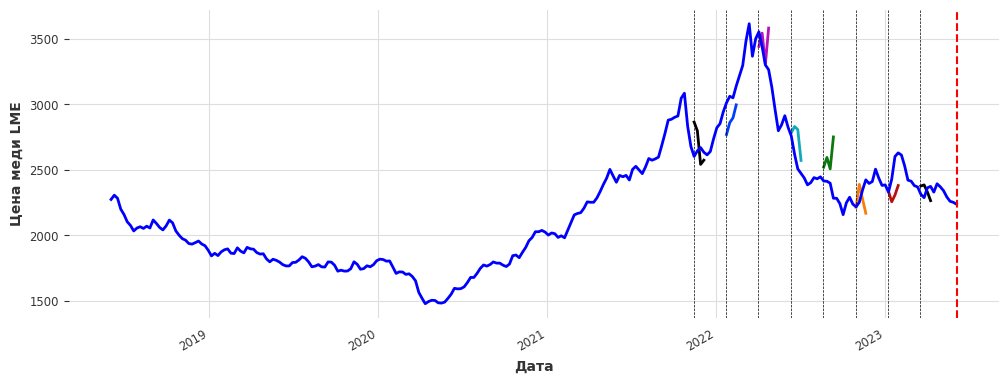

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts.plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic3.png', dpi=400, format='png')

Text(0.5, 0, 'Number of historical forecast')

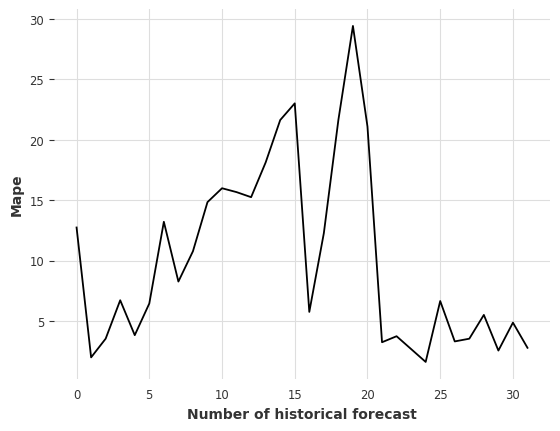

In [59]:
fig, ax = plt.subplots()
ax = sns.lineplot(bt_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of historical forecast')

### Fit and evaluate without refitting

In [57]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

prediction_curves, out_of_time_metrics_no_refit = evaluation_without_refitting(model_settings=new_best_params,
                                                                               backtest_settings=new_settings_for_backtest,
                                                                               df=df,
                                                                               candidates=candidates
                                                                              )

MAPE: 5.09 +- 2.48


In [58]:
print("Out-of-time MAPE without refit: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_no_refit), np.std(out_of_time_metrics_no_refit)))

Out-of-time MAPE without refit: 5.09 +- 2.48


Text(0.5, 0, 'Number of prediction on the out-of-time set')

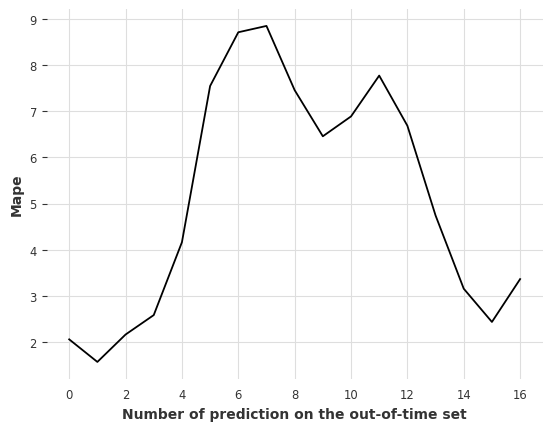

In [59]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_no_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

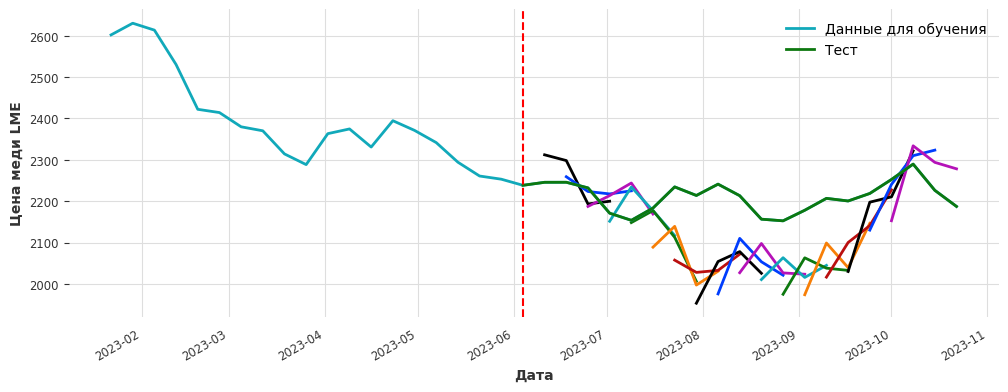

In [62]:


fig, ax = plt.subplots(figsize=(12, 4))
for key, value in prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
plt.savefig('pic3.png', dpi=400, format='png')

### Fit and evaluate with refitting

In [81]:
candidates = ['bloomberg_metals_price_mean_4',
              'ftse_index_change_mean_52',
              'USD_EUR_rate_std_26',
              'usa_gdp_increment_value',
              'rual_price_std_4',
              'australia_inflation_increment_by_mean_26',
              'australia_inflation_std_26',
              'australia_pmi_std_13']

prediction_curves, out_of_time_metrics_refit = evaluation_with_refitting(model_settings=new_best_params,
                                                                            backtest_settings=new_settings_for_backtest,
                                                                            df=df,
                                                                            candidates=candidates
                                                                           )

MAPE: 21.54 +- 1.44


In [83]:
print("Out-of-time MAPE without refit: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_refit), np.std(out_of_time_metrics_refit)))

Out-of-time MAPE without refit: 21.54 +- 1.44


Text(0.5, 0, 'Number of prediction on the out-of-time set')

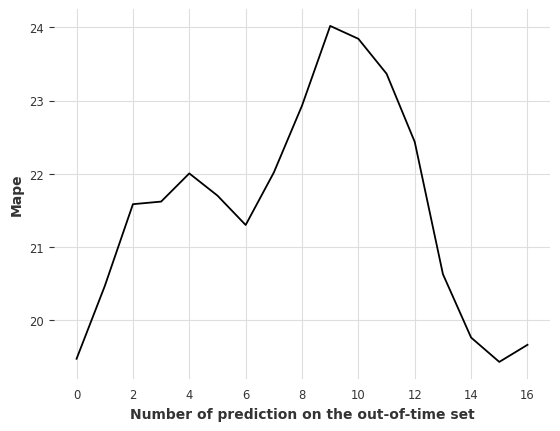

In [85]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

<Axes: xlabel='date'>

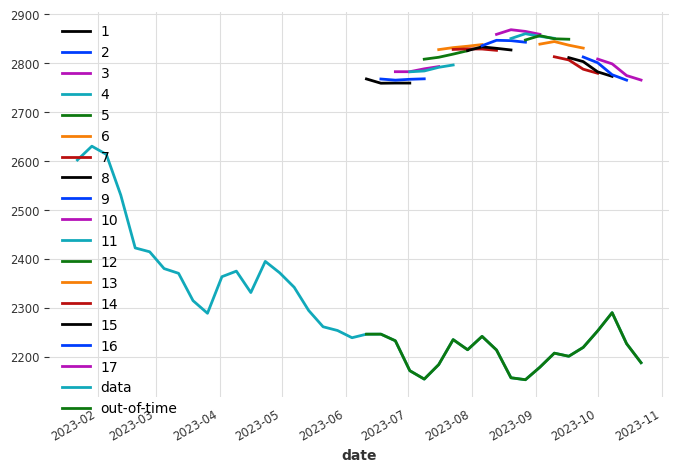

In [86]:
plt.figure(figsize=(8,5))
for key, value in prediction_curves.items():
    value.plot(label=key)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='data')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time')

### Evaluate train metrics without refitting

In [64]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

In [65]:
train_metrics = train_metric_evaluation(model_settings=new_best_params,
                                        backtest_settings=new_settings_for_backtest,
                                        df=df,
                                        candidates=candidates)

MAPE: 11.75 +- 12.71


In [66]:
np.mean(train_metrics), np.std(train_metrics)

(11.74593188026683, 12.708235260414336)

Text(0.5, 0, 'Number of prediction on the out-of-time set')

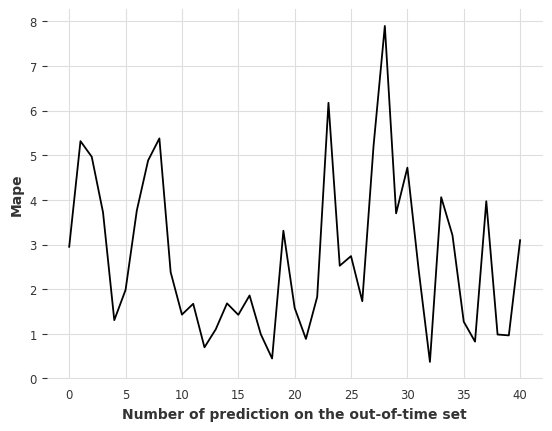

In [92]:
fig, ax = plt.subplots()
ax = sns.lineplot(train_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [96]:
metrics_dict = {
    "train_mean_mape":np.mean(train_metrics),
    "train_std_mape":np.std(train_metrics),
    "backtest_mean_mape":np.mean(bt_metrics),
    "backtest_std_mape":np.std(bt_metrics),
    "test_mean_mape_no_reffit":np.mean(out_of_time_metrics_no_refit),
    "test_std_mape_no_reffit":np.std(out_of_time_metrics_no_refit),
    "test_mean_mape_reffit":np.mean(out_of_time_metrics_refit),
    "test_std_mape_reffit":np.std(out_of_time_metrics_refit),
}
params = new_best_params | new_settings_for_backtest

In [97]:
metrics_dict

{'train_mean_mape': 2.7176062773993332,
 'train_std_mape': 1.7625621857696292,
 'backtest_mean_mape': 10.085882897643685,
 'backtest_std_mape': 7.49027008124043,
 'test_mean_mape_no_reffit': 7.206361656816628,
 'test_std_mape_no_reffit': 1.1254847389027458,
 'test_mean_mape_reffit': 21.543207929010645,
 'test_std_mape_reffit': 1.4447026421019704}

In [98]:
params

{'lags': 4,
 'lags_past_covariates': 58,
 'n_estimators': 100,
 'max_depth': 11,
 'min_samples_split': 2,
 'max_features': 'log2',
 'max_samples': 0.2,
 'rolling_window': False}